In [54]:
import os
import db_builder.db_handler as dbh
import numpy as np
import cv2
from torchvision import transforms
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import logging
from getpass import getpass
from datetime import datetime
from PIL import Image
from torchvision import datasets
import torch
import torchvision.models as models
import torch.nn as nn
import torch
#from torchvision.transforms import transforms
from torchvision import datasets
import os
import cv2
from statistics import mode
from collections import Counter

In [55]:
logging.getLogger('sqlalchemy').setLevel(logging.WARNING)
db_params = {
    'user': 'postgres',
    'password': getpass('Please enter DB pw'),  # enter your DB password
    'host': 'localhost',  # 'localhost' or IP address
    'port': '5432',  # '5432'
    'database': 'ttdatabase',  #tensionTerminator
}
toolcheck = dbh.DB_Conn(db_params)
toolcheck.connect()
engine = toolcheck.get_engine()

Connected to PostgreSQL, DB: ttdatabase


In [56]:
def trigger_crop(image):
    crop_box = (400, 450, 550, 550)
    cropped_image = transforms.functional.crop(image, *crop_box)
    return cropped_image


def video_to_image_converter(source_path: str, output_path: str, crop=False):
    vidcap = cv2.VideoCapture(source_path)
    os.makedirs(output_path, exist_ok=True)
    count = 0

    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    #fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    fps = 30

    while count < total_frames:
        success, image = vidcap.read()

        if count % int(fps) == 0:
            if not image is None and not image.size == 0:
                transform_test = transforms.ToPILImage()
                image = transform_test(image)
                if crop:
                    image = trigger_crop(image)
                image = np.asarray(image)
                cv2.imwrite(f"{output_path}/{count}.png", image)  # save frame as PNG file

        count += 1

    vidcap.release()
    cv2.destroyAllWindows()
    
def checkImage(path: str, transfer_model, orig_set, transforms_wt):

    img = Image.open(path)
    img_tensor = transforms_wt(img).unsqueeze(0)
    prediction = transfer_model(img_tensor.to("cuda"))
    predicted_probabilities = torch.softmax(prediction, dim=1)
    predicted_class_idx = torch.argmax(prediction).item()
    predicted_class = orig_set.classes[predicted_class_idx]
    

    # Get the confidence score for the predicted class
    confidence = predicted_probabilities[0, predicted_class_idx].item() * 100  # Convert to percentage

    return predicted_class, confidence


transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [57]:
directory = "tmp"
if not os.path.exists(directory):
    os.makedirs(directory)
    
video_source = toolcheck.get_filepath_by_loop_id(146)
video_to_image_converter(video_source, directory, True)


2023-11-26 18:22:03,294 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-11-26 18:22:03,294 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-26 18:22:03,295 INFO sqlalchemy.engine.Engine select current_schema()
2023-11-26 18:22:03,296 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-26 18:22:03,297 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-11-26 18:22:03,298 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-26 18:22:03,299 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-26 18:22:03,301 INFO sqlalchemy.engine.Engine SELECT file_path FROM video WHERE loop_id = %(loop_id)s AND device = 'rgbCam'
2023-11-26 18:22:03,302 INFO sqlalchemy.engine.Engine [generated in 0.00061s] {'loop_id': 146}


In [58]:
orig_set = datasets.ImageFolder(
    root='C:\\Users\\Pirmin.000\\PycharmProjects\\IGP\\data\\tool_finder\\10_11_2023_21_05_33',
    transform=transforms_wt
)

In [59]:
orig_set.classes

['duoballs', 'trigger']

In [60]:
transfer_model = models.resnet152()
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,2)
)
transfer_model_state_dict = torch.load("C:\\Users\\Pirmin.000\\PycharmProjects\\IGP\\models\\tool_finder\\10_11_2023_21_05_33\\model.pt")
transfer_model.load_state_dict(transfer_model_state_dict)
transfer_model.to("cuda")
transfer_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

100%|██████████| 111/111 [00:05<00:00, 19.67it/s]


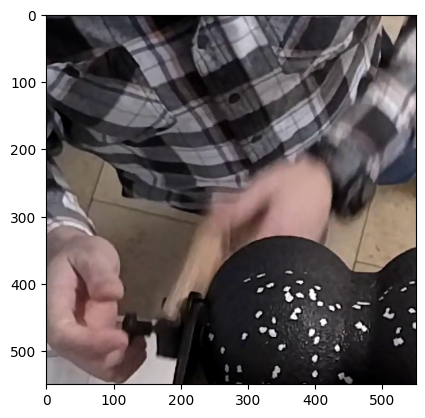

In [61]:
dataset = []
conf = []
directory = "tmp"

for filename in tqdm(os.listdir(directory)):
    f = os.path.join(directory, filename)
    #print(f)
    predicted_class, confidence = checkImage(f, transfer_model, orig_set, transforms_wt)
    conf.append(confidence)
    dataset.append(predicted_class)

    os.remove(f)
os.rmdir(directory)
dataset_confidence = sum(conf)/len(conf)

In [62]:
dataset_confidence

99.99322096506755

In [63]:
from collections import Counter

In [64]:
test = Counter(dataset)

In [65]:
test

Counter({'trigger': 76, 'duoballs': 35})

In [66]:
test[orig_set.classes[0]]

35

In [67]:
test[orig_set.classes[1]]

76

<video controls src=video_source />

In [68]:
video_source

'D:/BigBlock_01/tt_video_data/videos-2023-10-13 14_17_29.900262/rgbCam.h265.mp4'